# Application of Doc2Vec in gensim

on facebook posts from politicans in the German election 2017

**GOAL:** to let the model find a distinctiveness in the data, e.g. difference between party candidates

**Approach**:

- two models **PV-DBOW** and **PV-DM**
- 100 dimensions
- for 1, 5, 10, 50 and 100 epochs
- ...

*Remember:*
- one post = one doc

**Solution:** 
- Gensim allows to tag documents. Our tag = name of the candidate
- model creates and trains vectors for the candidates

#### Code

In [1]:
from plotly import __version__
from plotly import offline as pyoff

In [2]:
pyoff.init_notebook_mode(connected=True)

In [3]:
import pandas as pd
import numpy as np
import gensim
from nltk.corpus import stopwords
import logging
import multiprocessing
import os
from collections import namedtuple

FORMAT = '%(asctime)s %(levelname)s %(message)s'
DATEFORMAT = '%Y-%m-%d %H:%M:%S'
logging.basicConfig(level=logging.INFO,
                    format=FORMAT,
                    datefmt=DATEFORMAT)

In [4]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(parent_dir, 'data')
models_dir = os.path.join(parent_dir, 'models')
print('working directory: ', os.getcwd())
print('data directory:    ', data_dir, )
print('models directory:  ', models_dir)

working directory:  /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/notebooks
data directory:     /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/data
models directory:   /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/models


##### loads the data

In [5]:
data = pd.read_pickle(os.path.join(data_dir, 'data_clean_4cols.pickle'))
data = data.drop(['id'], axis=1)

pd.set_option('max_colwidth', 1000)
data.sample(n=10)

,from_name,message,Partei_ABK
23473,Michael Donth MdB,Gleich geht's los mit der Podiumsdiskussion des Reutlinger General-Anzeiger im kleinen Saal der Stadthalle Reutlingen. \n\nWas will mir nur die Stadthalle mit der Auslegung dieser Zeitschrift am Eingang sagen?🤔🤔,CDU
45924,Dirk Heidenblut - Mitglied des Bundestages,In Gedanken bin ich bei den Angehörigen und Verletzten. Ich wünsche ihnen Kraft und schnelle Gesundung. Wer da glaubt mit Terror Europa in die Knie zwingen zu können wird sich aber täuschen. Wir stehen in Europa zusammen.,SPD
92398,Caren Marks,In der Akademie des Sports Hannover haben wir das 15-jährige Jubiläum des Freiwilligen Dienstes im Sport gefeiert. Beeindruckend waren die Statements der jungen Freiwilligen. Das FSJ im Sport ist für alle ein Gewinn!,SPD
38221,Michael Groß,Ganz lang her..... mit meinem Freund Mahmut im Wahlkampf. Heiß war's😅,SPD
152196,"Karin Strenz, MdB","Vielen Dank für die Unterstützung, Michaela! #ErststimmeKarinStrenz #wahlkreis13",CDU
77616,Renate Künast,"Morgen im Bundestag: Fraktionsübergreifende Initiative ""Opfer der „Colonia Dignidad“ unterstützen, Aufarbeitung stärken!"" \nMit dem Beschluss erkennt der Bundestag an, dass die Aufarbeitung des Geschehenen trotz einzelner Maßnahmen noch als Aufgabe vor uns steht. Nach der Delegationsreise, die ich als Vorsitzende des Rechtsausschusses letztes Jahr mit Ausschusskollegen machte, dem Besuch der Colonia Dignidad und den Gesprächen mit Zeitzeugen war mir eindrücklich klar: Es müssen nun Taten folgen, und wir müssen uns auf die Seite der Opfer stellen.",GRÜNE
20772,Michael Theurer,"Wo die Mitte die FDP stark macht, da werden die Ränder schwach und die Politik wieder handlungsfähig. Macrons ""Aufstand der Gemäßigten"" ist auch in Deutschland möglich. Die Freien Demokraten stehen für eine starke Mitte: weltoffen, pro-europäisch, marktwirtschaftlich und rechtsstaatlich! Damit dringen wir auch in Deutschland zunehmend durch. Die Botschaft ist in Deutschland und Europa endlich angekommen: Zuschauen reicht nicht. Politische Zurückhaltung ist nicht mehr akzeptabel. Die liberalen Demokratien brauchen aktive Demokraten!",FDP
158740,Alexander Ulrich,"Nach der Demo"" Stopp US Base Ramstein"" gings weiter nach Ludwigshafen zum Wahlkampf mit Sahra Wagenknecht. Auch dort toller Besuch und gute Stimmung. Das war heute ein sehr guter Tag für Frieden, Gute Arbeit und soziale Gerechtigkeit!",DIE LINKE
112457,Sören Pellmann,Tolle Aktion gegen CETA in #Leipzig #Cetastoppen - Stimmen Sie mit NEIN Frau Constanze Krehl,DIE LINKE
175770,CSU Party,Heute Abend um 22:45 Uhr ist der CSU-Ehrenvorsitzende Edmund Stoiber zu Gast bei hart aber fair. Einschalten lohnt sich! #CSUtvTipp,CSU


##### gives doc2vec a challenge

In [6]:
# removes party mentions to test w
for char in ['SPD', 'spd', 'FDP', 'fdp', 'CDU' 'cdu', 'AfD' 'afd', 'AFD', 'Grüne', 'GRÜNE', 'Die Grünen', 'GRÜNEN', 'Linke', 'LINKE', 'CSU', 'csu', 'Die Linke', 'DIE LINKE',]:
        data.message = data.message.str.replace(char, '')

In [7]:
any(data.message.str.count('FDP')>0)

False

In [8]:
import string
import re
from nltk.tokenize.casual import TweetTokenizer

stopword_set = set(stopwords.words('german'))
tokenizer = TweetTokenizer
MessageDoc = namedtuple('MessageDoc', 'words tags')

alldocs = []  # Will hold all doacs in original order
for line_no, line in data.iterrows():
    message = line.message.lower()
    message = tokenizer().tokenize(message) 
    #import pdb; pdb.set_trace()
    words = [word.strip('#') for word in message if (word not in stopword_set 
                                          and word not in string.punctuation
                                          and not word.startswith('http')
                                          and not re.search(r'\d', word))]
    tags = [str(line_no), line['from_name']] #, line['Partei_ABK']] # line_no needs to be converted as string to be included in tags 
    alldocs.append(MessageDoc(words, tags))

In [9]:
message = data.message[7433].lower()
words = [word for word in tokenizer().tokenize(message) if word not in stopword_set and word not in string.punctuation]

print('Post', '\n', message, '\n', '\n', 'Tokenization', '\n', words)

Post 
 mein ärger der woche beim sonntags-stammtisch: die abschiebung von ahmad pouya. der afghanischen künstler und musiker lebte bis letzten freitag 6 jahre in deutschland, spricht fließend deutsch (und daneben fünf weitere sprachen) und war vorbildlich in deutschland integriert. er hat als dolmetscher gearbeitet und sollte eine beratungsstelle für geflüchtete leiten. nun wurde er - trotz vieler fürsprecher - eiskalt nach afghanistan abgeschoben um ein exempel zu statuieren. noch immer bin ich fassungslos über dieses vorgehen des innenministers. 
 
 Tokenization 
 ['ärger', 'woche', 'beim', 'sonntags-stammtisch', 'abschiebung', 'ahmad', 'pouya', 'afghanischen', 'künstler', 'musiker', 'lebte', 'letzten', 'freitag', '6', 'jahre', 'deutschland', 'spricht', 'fließend', 'deutsch', 'daneben', 'fünf', 'weitere', 'sprachen', 'vorbildlich', 'deutschland', 'integriert', 'dolmetscher', 'gearbeitet', 'beratungsstelle', 'geflüchtete', 'leiten', 'wurde', 'trotz', 'vieler', 'fürsprecher', 'eiskalt'

In [10]:
alldocs[7433]

MessageDoc(words=['ärger', 'woche', 'beim', 'sonntags-stammtisch', 'abschiebung', 'ahmad', 'pouya', 'afghanischen', 'künstler', 'musiker', 'lebte', 'letzten', 'freitag', 'jahre', 'deutschland', 'spricht', 'fließend', 'deutsch', 'daneben', 'fünf', 'weitere', 'sprachen', 'vorbildlich', 'deutschland', 'integriert', 'dolmetscher', 'gearbeitet', 'beratungsstelle', 'geflüchtete', 'leiten', 'wurde', 'trotz', 'vieler', 'fürsprecher', 'eiskalt', 'afghanistan', 'abgeschoben', 'exempel', 'statuieren', 'immer', 'fassungslos', 'vorgehen', 'innenministers'], tags=['7433', 'Margarete Bause'])

In [11]:
len(alldocs)

177307

In [12]:
cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

# doc2vec model

#### sets parameters of the models

ran several models with changing parameters

In [13]:
from collections import OrderedDict

models = [
    #gensim.models.Doc2Vec(dm=0, size=60, negative=5, hs=0, min_count=5, workers=cores),
    gensim.models.Doc2Vec(dm=0, dbow_words=0, size=100, negative=5, hs=0, min_count=5, workers=cores),
    #gensim.models.Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, hs=0, min_count=2, iter=1, workers=cores),
    gensim.models.Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=5, workers=cores),
]

#### builds vocabulary

In [14]:
# Speed up setup by sharing results of the 1st model's vocabulary scan
models[0].build_vocab(alldocs)  # PV-DM w/ concat requires one special NULL word so it serves as template
print(models[0])
for model in models[1:]:
    model.reset_from(models[0])
    print(model)

2018-03-10 19:01:51 INFO collecting all words and their counts
2018-03-10 19:01:51 INFO PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2018-03-10 19:01:51 INFO PROGRESS: at example #10000, processed 248212 words (1175899/s), 44067 word types, 10064 tags
2018-03-10 19:01:51 INFO PROGRESS: at example #20000, processed 494620 words (1096794/s), 69501 word types, 20133 tags
2018-03-10 19:01:51 INFO PROGRESS: at example #30000, processed 774576 words (1080003/s), 94020 word types, 30192 tags
2018-03-10 19:01:52 INFO PROGRESS: at example #40000, processed 1003726 words (1084546/s), 111211 word types, 40251 tags
2018-03-10 19:01:52 INFO PROGRESS: at example #50000, processed 1226999 words (1057001/s), 125130 word types, 50306 tags
2018-03-10 19:01:52 INFO PROGRESS: at example #60000, processed 1473461 words (1116351/s), 139348 word types, 60365 tags
2018-03-10 19:01:52 INFO PROGRESS: at example #70000, processed 1740712 words (1070961/s), 156916 word types, 70415 tags


Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)
Doc2Vec(dm/m,d100,n5,w10,mc5,s0.001,t4)


In [15]:
models_by_name = OrderedDict((str(model), model) for model in models[0:])

#from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
#models_by_name['dbow+dmm'] = ConcatenatedDoc2Vec([models[1], models[2]])
#models_by_name['dbow+dmc'] = ConcatenatedDoc2Vec([models[1], models[2]])

In [16]:
models_by_name

OrderedDict([('Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)',
              <gensim.models.doc2vec.Doc2Vec at 0x109648978>),
             ('Doc2Vec(dm/m,d100,n5,w10,mc5,s0.001,t4)',
              <gensim.models.doc2vec.Doc2Vec at 0x109648a90>)])

#### trains the models

In [31]:
epochs = 50

for name, train_model in models_by_name.items():
    train_model.train(alldocs, total_examples=len(alldocs), epochs=epochs, start_alpha=0.025, end_alpha=0.001)

2018-03-06 16:17:13 INFO training model with 4 workers on 57286 vocabulary and 100 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2018-03-06 16:17:14 INFO PROGRESS: at 0.11% examples, 243251 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:17:15 INFO PROGRESS: at 0.26% examples, 263509 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:17:16 INFO PROGRESS: at 0.39% examples, 279451 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:17:17 INFO PROGRESS: at 0.51% examples, 270169 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:17:18 INFO PROGRESS: at 0.63% examples, 263539 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:17:19 INFO PROGRESS: at 0.71% examples, 247476 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:17:20 INFO PROGRESS: at 0.82% examples, 247455 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:17:21 INFO PROGRESS: at 0.93% examples, 247402 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:17:22 INFO PROGRESS: at 1.01% examples, 237908 words/s, in_qsize 7, out_qsize 0
2018-03-06 1

2018-03-06 16:18:43 INFO PROGRESS: at 11.03% examples, 271466 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:18:44 INFO PROGRESS: at 11.17% examples, 271907 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:18:45 INFO PROGRESS: at 11.28% examples, 271656 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:18:46 INFO PROGRESS: at 11.41% examples, 272038 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:18:47 INFO PROGRESS: at 11.57% examples, 272617 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:18:48 INFO PROGRESS: at 11.71% examples, 273349 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:18:49 INFO PROGRESS: at 11.86% examples, 273751 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:18:50 INFO PROGRESS: at 12.01% examples, 274295 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:18:51 INFO PROGRESS: at 12.17% examples, 274817 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:18:52 INFO PROGRESS: at 12.30% examples, 275118 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:18:53 INFO PROGRESS: at 12.45% examp

2018-03-06 16:20:12 INFO PROGRESS: at 22.37% examples, 275886 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:20:13 INFO PROGRESS: at 22.52% examples, 276008 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:20:14 INFO PROGRESS: at 22.67% examples, 276223 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:20:15 INFO PROGRESS: at 22.82% examples, 276355 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:20:16 INFO PROGRESS: at 22.97% examples, 276543 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:20:17 INFO PROGRESS: at 23.12% examples, 276823 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:20:18 INFO PROGRESS: at 23.26% examples, 276937 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:20:19 INFO PROGRESS: at 23.39% examples, 277264 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:20:20 INFO PROGRESS: at 23.55% examples, 277472 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:20:21 INFO PROGRESS: at 23.67% examples, 277653 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:20:22 INFO PROGRESS: at 23.83% examp

2018-03-06 16:21:41 INFO PROGRESS: at 33.21% examples, 272621 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:21:42 INFO PROGRESS: at 33.35% examples, 272846 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:21:43 INFO PROGRESS: at 33.50% examples, 272984 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:21:45 INFO PROGRESS: at 33.64% examples, 273157 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:21:46 INFO PROGRESS: at 33.77% examples, 273228 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:21:47 INFO PROGRESS: at 33.92% examples, 273395 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:21:48 INFO PROGRESS: at 34.07% examples, 273524 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:21:49 INFO PROGRESS: at 34.22% examples, 273685 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:21:50 INFO PROGRESS: at 34.36% examples, 273886 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:21:51 INFO PROGRESS: at 34.51% examples, 273975 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:21:52 INFO PROGRESS: at 34.64% examp

2018-03-06 16:23:11 INFO PROGRESS: at 45.17% examples, 278225 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:23:12 INFO PROGRESS: at 45.28% examples, 278127 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:23:13 INFO PROGRESS: at 45.39% examples, 278115 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:23:14 INFO PROGRESS: at 45.54% examples, 278158 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:23:15 INFO PROGRESS: at 45.67% examples, 278264 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:23:16 INFO PROGRESS: at 45.81% examples, 278316 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:23:17 INFO PROGRESS: at 45.94% examples, 278295 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:23:18 INFO PROGRESS: at 46.07% examples, 278246 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:23:19 INFO PROGRESS: at 46.19% examples, 278202 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:23:20 INFO PROGRESS: at 46.33% examples, 278270 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:23:21 INFO PROGRESS: at 46.46% examp

2018-03-06 16:24:40 INFO PROGRESS: at 57.01% examples, 281112 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:24:41 INFO PROGRESS: at 57.11% examples, 280941 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:24:42 INFO PROGRESS: at 57.23% examples, 280881 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:24:43 INFO PROGRESS: at 57.35% examples, 280959 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:24:44 INFO PROGRESS: at 57.50% examples, 280979 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:24:45 INFO PROGRESS: at 57.62% examples, 280978 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:24:46 INFO PROGRESS: at 57.73% examples, 280960 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:24:47 INFO PROGRESS: at 57.85% examples, 280862 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:24:48 INFO PROGRESS: at 57.95% examples, 280717 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:24:49 INFO PROGRESS: at 58.06% examples, 280543 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:24:50 INFO PROGRESS: at 58.19% examp

2018-03-06 16:26:10 INFO PROGRESS: at 67.40% examples, 276515 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:26:11 INFO PROGRESS: at 67.45% examples, 276129 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:26:12 INFO PROGRESS: at 67.48% examples, 275701 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:26:13 INFO PROGRESS: at 67.50% examples, 275291 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:26:14 INFO PROGRESS: at 67.54% examples, 274919 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:26:15 INFO PROGRESS: at 67.59% examples, 274568 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:26:16 INFO PROGRESS: at 67.63% examples, 274245 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:26:17 INFO PROGRESS: at 67.68% examples, 273938 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:26:19 INFO PROGRESS: at 67.74% examples, 273669 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:26:20 INFO PROGRESS: at 67.80% examples, 273367 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:26:21 INFO PROGRESS: at 67.85% examp

2018-03-06 16:27:41 INFO PROGRESS: at 76.21% examples, 267535 words/s, in_qsize 6, out_qsize 1
2018-03-06 16:27:42 INFO PROGRESS: at 76.33% examples, 267577 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:27:43 INFO PROGRESS: at 76.43% examples, 267481 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:27:44 INFO PROGRESS: at 76.53% examples, 267338 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:27:45 INFO PROGRESS: at 76.62% examples, 267162 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:27:46 INFO PROGRESS: at 76.69% examples, 266966 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:27:47 INFO PROGRESS: at 76.74% examples, 266740 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:27:48 INFO PROGRESS: at 76.82% examples, 266571 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:27:49 INFO PROGRESS: at 76.90% examples, 266411 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:27:50 INFO PROGRESS: at 76.98% examples, 266213 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:27:51 INFO PROGRESS: at 77.04% examp

2018-03-06 16:29:10 INFO PROGRESS: at 86.76% examples, 266445 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:29:11 INFO PROGRESS: at 86.90% examples, 266470 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:29:13 INFO PROGRESS: at 87.04% examples, 266488 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:29:14 INFO PROGRESS: at 87.17% examples, 266509 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:29:15 INFO PROGRESS: at 87.30% examples, 266569 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:29:16 INFO PROGRESS: at 87.45% examples, 266609 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:29:17 INFO PROGRESS: at 87.59% examples, 266692 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:29:18 INFO PROGRESS: at 87.72% examples, 266749 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:29:19 INFO PROGRESS: at 87.88% examples, 266807 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:29:20 INFO PROGRESS: at 88.04% examples, 266893 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:29:21 INFO PROGRESS: at 88.17% examp

2018-03-06 16:30:40 INFO PROGRESS: at 97.81% examples, 266967 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:30:41 INFO PROGRESS: at 97.93% examples, 266948 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:30:42 INFO PROGRESS: at 98.05% examples, 266926 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:30:43 INFO PROGRESS: at 98.14% examples, 266851 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:30:44 INFO PROGRESS: at 98.25% examples, 266789 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:30:45 INFO PROGRESS: at 98.36% examples, 266778 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:30:47 INFO PROGRESS: at 98.48% examples, 266719 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:30:48 INFO PROGRESS: at 98.62% examples, 266750 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:30:49 INFO PROGRESS: at 98.77% examples, 266822 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:30:50 INFO PROGRESS: at 98.93% examples, 266891 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:30:51 INFO PROGRESS: at 99.08% examp

2018-03-06 16:32:05 INFO PROGRESS: at 6.34% examples, 206622 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:32:06 INFO PROGRESS: at 6.44% examples, 206420 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:32:07 INFO PROGRESS: at 6.55% examples, 206157 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:32:08 INFO PROGRESS: at 6.62% examples, 205628 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:32:09 INFO PROGRESS: at 6.71% examples, 205062 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:32:10 INFO PROGRESS: at 6.79% examples, 204875 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:32:11 INFO PROGRESS: at 6.89% examples, 204994 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:32:12 INFO PROGRESS: at 6.99% examples, 205043 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:32:13 INFO PROGRESS: at 7.11% examples, 205367 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:32:15 INFO PROGRESS: at 7.22% examples, 205604 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:32:16 INFO PROGRESS: at 7.32% examples, 206385

2018-03-06 16:33:35 INFO PROGRESS: at 15.49% examples, 215974 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:33:36 INFO PROGRESS: at 15.60% examples, 216159 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:33:37 INFO PROGRESS: at 15.71% examples, 216452 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:33:38 INFO PROGRESS: at 15.81% examples, 216467 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:33:39 INFO PROGRESS: at 15.90% examples, 216210 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:33:40 INFO PROGRESS: at 16.01% examples, 216360 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:33:41 INFO PROGRESS: at 16.12% examples, 216445 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:33:43 INFO PROGRESS: at 16.23% examples, 216541 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:33:44 INFO PROGRESS: at 16.33% examples, 216682 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:33:45 INFO PROGRESS: at 16.44% examples, 216686 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:33:46 INFO PROGRESS: at 16.53% examp

2018-03-06 16:35:06 INFO PROGRESS: at 23.76% examples, 210924 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:35:07 INFO PROGRESS: at 23.87% examples, 210983 words/s, in_qsize 6, out_qsize 1
2018-03-06 16:35:08 INFO PROGRESS: at 23.97% examples, 211049 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:35:09 INFO PROGRESS: at 24.09% examples, 211046 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:35:10 INFO PROGRESS: at 24.21% examples, 211182 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:35:11 INFO PROGRESS: at 24.28% examples, 211077 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:35:12 INFO PROGRESS: at 24.38% examples, 211134 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:35:13 INFO PROGRESS: at 24.49% examples, 211062 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:35:14 INFO PROGRESS: at 24.60% examples, 211159 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:35:15 INFO PROGRESS: at 24.72% examples, 211300 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:35:16 INFO PROGRESS: at 24.81% examp

2018-03-06 16:36:36 INFO PROGRESS: at 32.31% examples, 210181 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:36:37 INFO PROGRESS: at 32.41% examples, 210178 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:36:38 INFO PROGRESS: at 32.51% examples, 210118 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:36:39 INFO PROGRESS: at 32.61% examples, 210095 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:36:40 INFO PROGRESS: at 32.71% examples, 210110 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:36:41 INFO PROGRESS: at 32.82% examples, 210162 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:36:42 INFO PROGRESS: at 32.91% examples, 210153 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:36:43 INFO PROGRESS: at 33.03% examples, 210233 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:36:44 INFO PROGRESS: at 33.14% examples, 210309 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:36:45 INFO PROGRESS: at 33.24% examples, 210317 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:36:46 INFO PROGRESS: at 33.32% examp

2018-03-06 16:38:07 INFO PROGRESS: at 40.10% examples, 205661 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:38:08 INFO PROGRESS: at 40.21% examples, 205719 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:38:09 INFO PROGRESS: at 40.32% examples, 205853 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:38:10 INFO PROGRESS: at 40.43% examples, 205886 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:38:11 INFO PROGRESS: at 40.55% examples, 205933 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:38:12 INFO PROGRESS: at 40.66% examples, 205978 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:38:13 INFO PROGRESS: at 40.76% examples, 206029 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:38:14 INFO PROGRESS: at 40.87% examples, 206136 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:38:15 INFO PROGRESS: at 40.99% examples, 206189 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:38:16 INFO PROGRESS: at 41.09% examples, 206222 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:38:17 INFO PROGRESS: at 41.20% examp

2018-03-06 16:39:37 INFO PROGRESS: at 49.15% examples, 208295 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:39:38 INFO PROGRESS: at 49.25% examples, 208284 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:39:39 INFO PROGRESS: at 49.35% examples, 208376 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:39:40 INFO PROGRESS: at 49.46% examples, 208383 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:39:41 INFO PROGRESS: at 49.56% examples, 208441 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:39:42 INFO PROGRESS: at 49.67% examples, 208504 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:39:43 INFO PROGRESS: at 49.79% examples, 208563 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:39:45 INFO PROGRESS: at 49.91% examples, 208590 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:39:46 INFO PROGRESS: at 50.01% examples, 208641 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:39:47 INFO PROGRESS: at 50.12% examples, 208676 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:39:48 INFO PROGRESS: at 50.23% examp

2018-03-06 16:41:07 INFO PROGRESS: at 58.11% examples, 209961 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:41:08 INFO PROGRESS: at 58.23% examples, 210012 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:41:09 INFO PROGRESS: at 58.34% examples, 210094 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:41:10 INFO PROGRESS: at 58.43% examples, 210056 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:41:11 INFO PROGRESS: at 58.54% examples, 210018 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:41:12 INFO PROGRESS: at 58.63% examples, 209990 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:41:13 INFO PROGRESS: at 58.74% examples, 210047 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:41:14 INFO PROGRESS: at 58.83% examples, 210004 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:41:16 INFO PROGRESS: at 58.91% examples, 209951 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:41:17 INFO PROGRESS: at 59.02% examples, 209931 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:41:18 INFO PROGRESS: at 59.11% examp

2018-03-06 16:42:38 INFO PROGRESS: at 67.11% examples, 211072 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:42:39 INFO PROGRESS: at 67.21% examples, 211094 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:42:40 INFO PROGRESS: at 67.30% examples, 211113 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:42:41 INFO PROGRESS: at 67.39% examples, 211121 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:42:42 INFO PROGRESS: at 67.51% examples, 211138 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:42:43 INFO PROGRESS: at 67.60% examples, 211144 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:42:44 INFO PROGRESS: at 67.69% examples, 211146 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:42:45 INFO PROGRESS: at 67.79% examples, 211167 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:42:46 INFO PROGRESS: at 67.91% examples, 211171 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:42:47 INFO PROGRESS: at 68.01% examples, 211221 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:42:48 INFO PROGRESS: at 68.13% examp

2018-03-06 16:44:07 INFO PROGRESS: at 76.23% examples, 212590 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:44:08 INFO PROGRESS: at 76.34% examples, 212660 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:44:09 INFO PROGRESS: at 76.46% examples, 212664 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:44:11 INFO PROGRESS: at 76.55% examples, 212619 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:44:12 INFO PROGRESS: at 76.65% examples, 212572 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:44:13 INFO PROGRESS: at 76.73% examples, 212539 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:44:14 INFO PROGRESS: at 76.84% examples, 212566 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:44:15 INFO PROGRESS: at 76.95% examples, 212586 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:44:16 INFO PROGRESS: at 77.06% examples, 212615 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:44:17 INFO PROGRESS: at 77.16% examples, 212644 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:44:18 INFO PROGRESS: at 77.27% examp

2018-03-06 16:45:38 INFO PROGRESS: at 85.35% examples, 213560 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:45:39 INFO PROGRESS: at 85.46% examples, 213578 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:45:40 INFO PROGRESS: at 85.58% examples, 213621 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:45:41 INFO PROGRESS: at 85.68% examples, 213662 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:45:42 INFO PROGRESS: at 85.78% examples, 213677 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:45:43 INFO PROGRESS: at 85.90% examples, 213686 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:45:44 INFO PROGRESS: at 86.00% examples, 213704 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:45:45 INFO PROGRESS: at 86.11% examples, 213712 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:45:46 INFO PROGRESS: at 86.21% examples, 213720 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:45:47 INFO PROGRESS: at 86.29% examples, 213698 words/s, in_qsize 8, out_qsize 0
2018-03-06 16:45:48 INFO PROGRESS: at 86.39% examp

2018-03-06 16:47:08 INFO PROGRESS: at 94.44% examples, 214287 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:47:09 INFO PROGRESS: at 94.55% examples, 214277 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:47:10 INFO PROGRESS: at 94.64% examples, 214248 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:47:12 INFO PROGRESS: at 94.72% examples, 214205 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:47:13 INFO PROGRESS: at 94.80% examples, 214162 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:47:14 INFO PROGRESS: at 94.90% examples, 214174 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:47:15 INFO PROGRESS: at 95.01% examples, 214164 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:47:16 INFO PROGRESS: at 95.12% examples, 214188 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:47:17 INFO PROGRESS: at 95.24% examples, 214208 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:47:18 INFO PROGRESS: at 95.33% examples, 214244 words/s, in_qsize 7, out_qsize 0
2018-03-06 16:47:19 INFO PROGRESS: at 95.43% examp

#### saves the models

In [33]:
# saves the model
from datetime import datetime

count = 1
for name, trained_model in models_by_name.items():
    #import pdb; pdb.set_trace()
    name = name.replace('/', '')
    if count>len(models):
        break
    else:
        trained_model.save(os.path.join(models_dir, name + '_e' + str(epochs) + '23022018' + '.model'))
        count += 1
#logger.info('model saved')

2018-03-06 17:04:08 INFO saving Doc2Vec object under /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e5023022018.model, separately None
2018-03-06 17:04:08 INFO not storing attribute syn0norm
2018-03-06 17:04:08 INFO storing np array 'doctag_syn0' to /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e5023022018.model.docvecs.doctag_syn0.npy
2018-03-06 17:04:10 INFO not storing attribute cum_table
2018-03-06 17:04:13 INFO saved /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e5023022018.model
2018-03-06 17:04:13 INFO saving Doc2Vec object under /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/

#### creates candidate specific data

In [17]:
data2 = pd.read_pickle(os.path.join(data_dir, 'data_clean_4cols.pickle'))
candidate_data = (data2.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
#                      .set_index('from_name')
                 )

In [18]:
candidate_data.tail(10)

,from_name,Partei_ABK
173042,Dr. Daniela De Ridder,SPD
173559,Björn Simon,CDU
173902,Waldemar Westermayer,CDU
173963,AfD Party,AfD
174481,CDU Party,CDU
174974,SPD Party,SPD
175488,CSU Party,CSU
176078,GRÜNE Party,GRÜNE
176425,FDP Party,FDP
176969,DIE LINKE Party,DIE LINKE


In [19]:
party_colors = {'AfD': 'rgb(0, 0, 153)',
                'DIE LINKE': 'rgb(204, 0, 102)',
                'GRÜNE': 'rgb(0, 153, 0)',
                'CSU': 'rgb(102, 178, 255)',
                'CDU': 'rgb(0, 0, 0)',
                'FDP': 'rgb(255, 255, 51)',
                'SPD': 'rgb(255, 0, 0)'}

candidate_data['color'] = candidate_data['Partei_ABK'].map(party_colors)

party_colors = {'AfD': 'xkcd:blue',
                'DIE LINKE': 'xkcd:magenta',
                'GRÜNE': 'xkcd:grass green',
                'CSU': 'xkcd:sky blue',
                'CDU': 'xkcd:black',
                'FDP': 'xkcd:goldenrod',
                'SPD': 'xkcd:red'}
candidate_data['color2'] = candidate_data['Partei_ABK'].map(party_colors)

leaders = ['Sahra Wagenknecht',
'Dietmar Bartsch',
'Katrin Göring-Eckardt',
'Cem Özdemir',
'Martin Schulz',
'Angela Merkel',
'Joachim Herrmann',
'Alexander Gauland',
'Alice Weidel']

candidate_data['leader'] = data['from_name'].isin(leaders)

candidate_data['size'] = 5
candidate_data.loc[candidate_data['from_name'].str.contains('Party'),'size'] = 10
candidate_data.loc[candidate_data['leader'], 'size'] = 8

candidate_data['symbol'] = 100
candidate_data.loc[candidate_data['from_name'].str.contains('Party'), 'symbol'] = 101
candidate_data.loc[candidate_data['leader'], 'symbol'] = 114

candidate_data['symbol2'] = '.'
candidate_data.loc[candidate_data['from_name'].str.contains('Party'), 'symbol2'] = 's'
candidate_data.loc[candidate_data['leader'], 'symbol2'] = 'h'

# plots

### Code

In [20]:
from sklearn.manifold import TSNE
import plotly.graph_objs as go
from plotly import tools

from time import time
import numpy as np

In [21]:
model1_name = 'Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e123022018.model'
model2_name = 'Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e123022018.model' 
model3_name = 'Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e523022018.model'
model4_name = 'Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e523022018.model'
model5_name = 'Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e1023022018.model'
model6_name = 'Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e1023022018.model'
model7_name = 'Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e2023022018.model'
model8_name = 'Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e2023022018.model'
model9_name = 'Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e5023022018.model'
model10_name = 'Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e5023022018.model'
model11_name = 'Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e10023022018.model'
model12_name = 'Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e10023022018.model'

model1 = gensim.models.Doc2Vec.load(os.path.join(models_dir, model1_name))
model2 = gensim.models.Doc2Vec.load(os.path.join(models_dir, model2_name))
model3 = gensim.models.Doc2Vec.load(os.path.join(models_dir, model3_name))
model4 = gensim.models.Doc2Vec.load(os.path.join(models_dir, model4_name))
model5 = gensim.models.Doc2Vec.load(os.path.join(models_dir, model5_name))
model6 = gensim.models.Doc2Vec.load(os.path.join(models_dir, model6_name))
model7 = gensim.models.Doc2Vec.load(os.path.join(models_dir, model7_name))
model8 = gensim.models.Doc2Vec.load(os.path.join(models_dir, model8_name))
model9 = gensim.models.Doc2Vec.load(os.path.join(models_dir, model9_name))
model10 = gensim.models.Doc2Vec.load(os.path.join(models_dir, model10_name))
model11 = gensim.models.Doc2Vec.load(os.path.join(models_dir, model11_name))
model12 = gensim.models.Doc2Vec.load(os.path.join(models_dir, model12_name))

2018-03-10 19:02:11 INFO loading Doc2Vec object from /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e123022018.model
2018-03-10 19:02:13 INFO loading wv recursively from /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e123022018.model.wv.* with mmap=None
2018-03-10 19:02:13 INFO setting ignored attribute syn0norm to None
2018-03-10 19:02:13 INFO loading docvecs recursively from /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e123022018.model.docvecs.* with mmap=None
2018-03-10 19:02:13 INFO loading doctag_syn0 from /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/m

2018-03-10 19:02:31 INFO loading Doc2Vec object from /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e2023022018.model
2018-03-10 19:02:33 INFO loading wv recursively from /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e2023022018.model.wv.* with mmap=None
2018-03-10 19:02:33 INFO setting ignored attribute syn0norm to None
2018-03-10 19:02:33 INFO loading docvecs recursively from /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS1718/models/Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e2023022018.model.docvecs.* with mmap=None
2018-03-10 19:02:33 INFO loading doctag_syn0 from /Volumes/Datahouse/Users/Stipe/Documents/Studium/Master VWL/5 WS 2017/Seminar Information Systems/InformationSystemsWS171

In [22]:
model8.docvecs.doctags

{'0': Doctag(offset=0, word_count=27, doc_count=1),
 'Valentin Abel': Doctag(offset=1, word_count=2195, doc_count=93),
 '1': Doctag(offset=2, word_count=26, doc_count=1),
 '2': Doctag(offset=3, word_count=6, doc_count=1),
 '3': Doctag(offset=4, word_count=27, doc_count=1),
 '4': Doctag(offset=5, word_count=25, doc_count=1),
 '5': Doctag(offset=6, word_count=30, doc_count=1),
 '6': Doctag(offset=7, word_count=30, doc_count=1),
 '7': Doctag(offset=8, word_count=13, doc_count=1),
 '8': Doctag(offset=9, word_count=20, doc_count=1),
 '9': Doctag(offset=10, word_count=20, doc_count=1),
 '10': Doctag(offset=11, word_count=30, doc_count=1),
 '11': Doctag(offset=12, word_count=18, doc_count=1),
 '12': Doctag(offset=13, word_count=23, doc_count=1),
 '13': Doctag(offset=14, word_count=18, doc_count=1),
 '14': Doctag(offset=15, word_count=23, doc_count=1),
 '15': Doctag(offset=16, word_count=30, doc_count=1),
 '16': Doctag(offset=17, word_count=17, doc_count=1),
 '17': Doctag(offset=18, word_count

In [23]:
fig1 = tools.make_subplots(rows=1, cols=2, subplot_titles=[model1_name, model2_name])
fig2 = tools.make_subplots(rows=1, cols=2, subplot_titles=[model3_name, model4_name])
fig3 = tools.make_subplots(rows=1, cols=2, subplot_titles=[model5_name, model6_name])
fig4 = tools.make_subplots(rows=1, cols=2, subplot_titles=[model7_name, model8_name])

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



#### Reducing dimensionality with t-SNE (t-distributed stochastic neighbor embedding)

In [24]:
# vector for model one
mask = [tag in candidate_data['from_name'].values for tag in model1.docvecs.offset2doctag]
candidate_vecs = model1.docvecs.doctag_syn0[mask]

X = candidate_vecs
tsne = TSNE(n_components=2)
X_tsne1 = tsne.fit_transform(X)

# vector for model two
mask = [tag in candidate_data['from_name'].values for tag in model2.docvecs.offset2doctag]
candidate_vecs = model2.docvecs.doctag_syn0[mask]

X = candidate_vecs
tsne = TSNE(n_components=2)
X_tsne2 = tsne.fit_transform(X)

# vector for model three
mask = [tag in candidate_data['from_name'].values for tag in model3.docvecs.offset2doctag]
candidate_vecs = model3.docvecs.doctag_syn0[mask]

X = candidate_vecs
tsne = TSNE(n_components=2)
X_tsne3 = tsne.fit_transform(X)

# vector for model four
mask = [tag in candidate_data['from_name'].values for tag in model4.docvecs.offset2doctag]
candidate_vecs = model4.docvecs.doctag_syn0[mask]

X = candidate_vecs
tsne = TSNE(n_components=2)
X_tsne4 = tsne.fit_transform(X)

# vector for model five
mask = [tag in candidate_data['from_name'].values for tag in model5.docvecs.offset2doctag]
candidate_vecs = model5.docvecs.doctag_syn0[mask]

X = candidate_vecs
tsne = TSNE(n_components=2)
X_tsne5 = tsne.fit_transform(X)

# vector for model six
mask = [tag in candidate_data['from_name'].values for tag in model6.docvecs.offset2doctag]
candidate_vecs = model6.docvecs.doctag_syn0[mask]

X = candidate_vecs
tsne = TSNE(n_components=2)
X_tsne6 = tsne.fit_transform(X)

# vector for model seven
mask = [tag in candidate_data['from_name'].values for tag in model7.docvecs.offset2doctag]
candidate_vecs = model7.docvecs.doctag_syn0[mask]

X = candidate_vecs
tsne = TSNE(n_components=2)
X_tsne7 = tsne.fit_transform(X)

# vector for model eight
mask = [tag in candidate_data['from_name'].values for tag in model8.docvecs.offset2doctag]
candidate_vecs = model8.docvecs.doctag_syn0[mask]

X = candidate_vecs
tsne = TSNE(n_components=2)
X_tsne8 = tsne.fit_transform(X)

In [25]:
trace = go.Scatter(x=X_tsne1[:, 0], y=X_tsne1[:, 1],
                       mode='markers',
                       marker=dict(color=candidate_data['color'],
                                   size=candidate_data['size'],
                                   symbol=candidate_data['symbol'],
                                   showscale=False,
                                   line=dict(color='black', 
                                             width=1)),
                       text=candidate_data['from_name'])
    
fig1.append_trace(trace, 1, 1)

trace = go.Scatter(x=X_tsne2[:, 0], y=X_tsne2[:, 1],
                       mode='markers',
                       marker=dict(color=candidate_data['color'],
                                   size=candidate_data['size'],
                                   symbol=candidate_data['symbol'],
                                   showscale=False,
                                   line=dict(color='black', 
                                             width=1)),
                       text=candidate_data['from_name'])
    
fig1.append_trace(trace, 1, 2)

trace = go.Scatter(x=X_tsne3[:, 0], y=X_tsne3[:, 1],
                       mode='markers',
                       marker=dict(color=candidate_data['color'],
                                   size=candidate_data['size'],
                                   symbol=candidate_data['symbol'],
                                   showscale=False,
                                   line=dict(color='black', 
                                             width=1)),
                       text=candidate_data['from_name'])
    
fig2.append_trace(trace, 1, 1)

trace = go.Scatter(x=X_tsne4[:, 0], y=X_tsne4[:, 1],
                       mode='markers',
                       marker=dict(color=candidate_data['color'],
                                   size=candidate_data['size'],
                                   symbol=candidate_data['symbol'],
                                   showscale=False,
                                   line=dict(color='black', 
                                             width=1)),
                       text=candidate_data['from_name'])
    
fig2.append_trace(trace, 1, 2)

trace = go.Scatter(x=X_tsne5[:, 0], y=X_tsne5[:, 1],
                       mode='markers',
                       marker=dict(color=candidate_data['color'],
                                   size=candidate_data['size'],
                                   symbol=candidate_data['symbol'],
                                   showscale=False,
                                   line=dict(color='black', 
                                             width=1)),
                       text=candidate_data['from_name'])
    
fig3.append_trace(trace, 1, 1)

trace = go.Scatter(x=X_tsne6[:, 0], y=X_tsne6[:, 1],
                       mode='markers',
                       marker=dict(color=candidate_data['color'],
                                   size=candidate_data['size'],
                                   symbol=candidate_data['symbol'],
                                   showscale=False,
                                   line=dict(color='black', 
                                             width=1)),
                       text=candidate_data['from_name'])
    
fig3.append_trace(trace, 1, 2)

trace = go.Scatter(x=X_tsne7[:, 0], y=X_tsne7[:, 1],
                       mode='markers',
                       marker=dict(color=candidate_data['color'],
                                   size=candidate_data['size'],
                                   symbol=candidate_data['symbol'],
                                   showscale=False,
                                   line=dict(color='black', 
                                             width=1)),
                       text=candidate_data['from_name'])
    
fig4.append_trace(trace, 1, 1)

trace = go.Scatter(x=X_tsne8[:, 0], y=X_tsne8[:, 1],
                       mode='markers',
                       marker=dict(color=candidate_data['color'],
                                   size=candidate_data['size'],
                                   symbol=candidate_data['symbol'],
                                   showscale=False,
                                   line=dict(color='black', 
                                             width=1)),
                       text=candidate_data['from_name'])
    
fig4.append_trace(trace, 1, 2)

In [26]:
fig1['layout'].update(title='Models with epochs=1', showlegend=False)
fig2['layout'].update(title='Models with epochs=5', showlegend=False)
fig3['layout'].update(title='Models with epochs=10', showlegend=False)
fig4['layout'].update(title='Models with epochs=20', showlegend=False)

## t-SNE plots (t-distributed stochastic neighbor embedding)

an algorithm to reduce number of dimensions

/Volumes/Datahouse/Users/Stipe/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



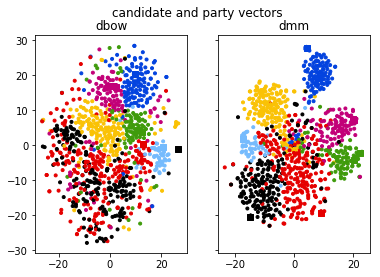

In [57]:
pyoff.iplot(fig1, filename='tsnePlot1_epochs1')

import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#ax1.plot(x, y)
#ax1.set_title('Sharing Y axis')
#ax2.scatter(x, y)
#plt.figure(num=None, figsize=(10, 8))  # set the figure size

markers = [".", "s", "h"]
for i, c in enumerate(np.unique(candidate_data['symbol2'])):
    ax1.scatter(X_tsne1[:,0][candidate_data['symbol2']==c], X_tsne1[:, 1][candidate_data['symbol2']==c], c=candidate_data['color2'][candidate_data['symbol2']==c], marker=markers[i])
    ax1.set_title('dbow')
    
for i, c in enumerate(np.unique(candidate_data['symbol2'])):
    ax2.scatter(X_tsne2[:,0][candidate_data['symbol2']==c], X_tsne2[:, 1][candidate_data['symbol2']==c], c=candidate_data['color2'][candidate_data['symbol2']==c], marker=markers[i])
    ax2.set_title('dmm')
#plt.scatter(X_tsne1[:, 0], X_tsne1[:, 1], c=candidate_data['color2'], marker=candidate_data.symbol2)
f.suptitle('candidate and party vectors')
#f.text(0.5, 0.8, "1 Epoch", size=10,
#         ha="center", va="center",
#         bbox=dict(boxstyle="round",
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   )
#         )
f.show()
f.savefig('tsne_e1.pdf', format='pdf', orientation='landscape')

/Volumes/Datahouse/Users/Stipe/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



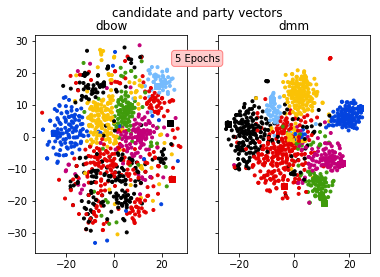

In [28]:
pyoff.iplot(fig2, filename='tsnePlot1_epochs5')

f2, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

for i, c in enumerate(np.unique(candidate_data['symbol2'])):
    ax1.scatter(X_tsne3[:,0][candidate_data['symbol2']==c], X_tsne3[:, 1][candidate_data['symbol2']==c], c=candidate_data['color2'][candidate_data['symbol2']==c], marker=markers[i])
    ax1.set_title('dbow')
    
for i, c in enumerate(np.unique(candidate_data['symbol2'])):
    ax2.scatter(X_tsne4[:,0][candidate_data['symbol2']==c], X_tsne4[:, 1][candidate_data['symbol2']==c], c=candidate_data['color2'][candidate_data['symbol2']==c], marker=markers[i])
    ax2.set_title('dmm')

f2.suptitle('candidate and party vectors')
f2.text(0.5, 0.8, "5 Epochs", size=10,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )
f2.show()
f2.savefig('tsne_e5.pdf', format='pdf', orientation='landscape')

/Volumes/Datahouse/Users/Stipe/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



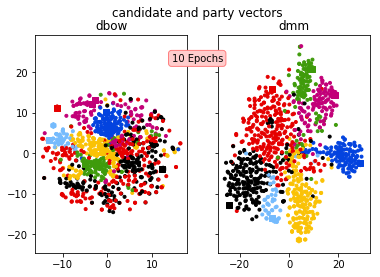

In [29]:
pyoff.iplot(fig3, filename='tsnePlot1_epochs10<b')

f3, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

for i, c in enumerate(np.unique(candidate_data['symbol2'])):
    ax1.scatter(X_tsne5[:,0][candidate_data['symbol2']==c], X_tsne5[:, 1][candidate_data['symbol2']==c], c=candidate_data['color2'][candidate_data['symbol2']==c], marker=markers[i])
    ax1.set_title('dbow')
    
for i, c in enumerate(np.unique(candidate_data['symbol2'])):
    ax2.scatter(X_tsne6[:,0][candidate_data['symbol2']==c], X_tsne6[:, 1][candidate_data['symbol2']==c], c=candidate_data['color2'][candidate_data['symbol2']==c], marker=markers[i])
    ax2.set_title('dmm')

f3.suptitle('candidate and party vectors')
f3.text(0.5, 0.8, "10 Epochs", size=10,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )
f3.show()
f3.savefig('tsne_e10.pdf', format='pdf', orientation='landscape')

/Volumes/Datahouse/Users/Stipe/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



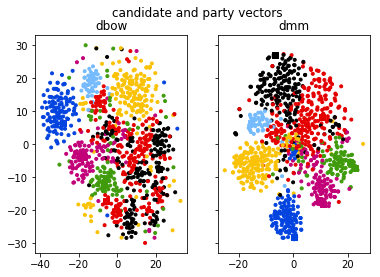

In [56]:
pyoff.iplot(fig4, filename='tsnePlot1_epochs20')

f4, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

for i, c in enumerate(np.unique(candidate_data['symbol2'])):
    ax1.scatter(X_tsne7[:,0][candidate_data['symbol2']==c], X_tsne7[:, 1][candidate_data['symbol2']==c], c=candidate_data['color2'][candidate_data['symbol2']==c], marker=markers[i])
    ax1.set_title('dbow')
    
for i, c in enumerate(np.unique(candidate_data['symbol2'])):
    ax2.scatter(X_tsne8[:,0][candidate_data['symbol2']==c], X_tsne8[:, 1][candidate_data['symbol2']==c], c=candidate_data['color2'][candidate_data['symbol2']==c], marker=markers[i])
    ax2.set_title('dmm')

f4.suptitle('candidate and party vectors')
#f4.text(0.5, 0.8, "20 Epochs", size=10,
#         ha="center", va="center",
#         bbox=dict(boxstyle="round",
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   )
#         )
f4.show()
f4.savefig('tsne_e20.pdf', format='pdf', orientation='landscape')

**But:** 

- we removed the party names in the posts to avoid that doc2vec identifies party names as the distinctive pattern in the data

# similarity between candidate and parties

#### Code

In [31]:
# calculate similarity for all candidates and parties
candidate1_data = (data2.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
                                   )
candidate2_data = (data2.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
                                   )
candidate3_data = (data2.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
                                   )
candidate4_data = (data2.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
                                   )
candidate5_data = (data2.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
                                   )
candidate6_data = (data2.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
                                   )
candidate7_data = (data2.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
                                   )
candidate8_data = (data2.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
                                   )
candidate9_data = (data2.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
                                   )

candidate10_data = (data2.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
                                   )

candidate11_data = (data2.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
                                   )

candidate12_data = (data2.drop(['id', 'message'], axis=1)
                      .drop_duplicates('from_name')
                                   )

# calculate similarity for all candidates and parties
for party in ['SPD Party', 'CDU Party', 'DIE LINKE Party', 'AfD Party', 'CSU Party', 'GRÜNE Party', 'FDP Party']:
    candidate1_data[party] = candidate1_data['from_name'].map(lambda candidate: model1.docvecs.similarity(candidate, party))
    candidate2_data[party] = candidate2_data['from_name'].map(lambda candidate: model2.docvecs.similarity(candidate, party))
    candidate3_data[party] = candidate3_data['from_name'].map(lambda candidate: model3.docvecs.similarity(candidate, party))
    candidate4_data[party] = candidate4_data['from_name'].map(lambda candidate: model4.docvecs.similarity(candidate, party))
    candidate5_data[party] = candidate5_data['from_name'].map(lambda candidate: model5.docvecs.similarity(candidate, party))
    candidate6_data[party] = candidate6_data['from_name'].map(lambda candidate: model6.docvecs.similarity(candidate, party))
    candidate7_data[party] = candidate6_data['from_name'].map(lambda candidate: model7.docvecs.similarity(candidate, party))
    candidate8_data[party] = candidate8_data['from_name'].map(lambda candidate: model8.docvecs.similarity(candidate, party))
    candidate9_data[party] = candidate9_data['from_name'].map(lambda candidate: model9.docvecs.similarity(candidate, party))
    candidate10_data[party] = candidate10_data['from_name'].map(lambda candidate: model10.docvecs.similarity(candidate, party))
    candidate11_data[party] = candidate11_data['from_name'].map(lambda candidate: model11.docvecs.similarity(candidate, party))
    candidate12_data[party] = candidate12_data['from_name'].map(lambda candidate: model12.docvecs.similarity(candidate, party))





# make a new column holding which party is most similar
candidate1_data['most similar'] = candidate1_data.loc[:,'SPD Party':].idxmax(axis=1)
candidate2_data['most similar'] = candidate2_data.loc[:,'SPD Party':].idxmax(axis=1)
candidate3_data['most similar'] = candidate3_data.loc[:,'SPD Party':].idxmax(axis=1)
candidate4_data['most similar'] = candidate4_data.loc[:,'SPD Party':].idxmax(axis=1)
candidate5_data['most similar'] = candidate5_data.loc[:,'SPD Party':].idxmax(axis=1)
candidate6_data['most similar'] = candidate6_data.loc[:,'SPD Party':].idxmax(axis=1)
candidate7_data['most similar'] = candidate7_data.loc[:,'SPD Party':].idxmax(axis=1)
candidate8_data['most similar'] = candidate8_data.loc[:,'SPD Party':].idxmax(axis=1)
candidate9_data['most similar'] = candidate9_data.loc[:,'SPD Party':].idxmax(axis=1)
candidate10_data['most similar'] = candidate10_data.loc[:,'SPD Party':].idxmax(axis=1)
candidate11_data['most similar'] = candidate11_data.loc[:,'SPD Party':].idxmax(axis=1)
candidate12_data['most similar'] = candidate12_data.loc[:,'SPD Party':].idxmax(axis=1)

In [32]:
candidate1_data

,from_name,Partei_ABK,SPD Party,CDU Party,DIE LINKE Party,AfD Party,CSU Party,GRÜNE Party,FDP Party,most similar
0,Valentin Abel,FDP,0.199991,0.255556,0.137110,0.143364,0.307093,0.152091,0.364162,FDP Party
93,Dr. Michael von Abercron,CDU,0.420127,0.343239,0.237742,0.114918,0.181848,0.215464,0.163653,SPD Party
168,Grigorios Aggelidis,FDP,0.290441,0.118464,0.145801,0.176591,0.162208,0.255052,0.227857,SPD Party
215,Diyar Agu,DIE LINKE,0.194315,0.376704,0.344184,0.035345,0.261681,0.105432,0.158466,CDU Party
269,Gökay Akbulut DIE LINKE,DIE LINKE,0.182332,0.163305,0.440228,0.125347,0.152439,0.238991,0.311748,DIE LINKE Party
284,Rolf Albach,FDP,0.201251,0.202369,0.289722,0.191937,-0.000102,0.230604,0.132442,DIE LINKE Party
406,Stephan Albani MdB,CDU,0.178453,0.207142,0.105760,0.114739,0.048978,0.177758,0.096069,CDU Party
922,Katrin Albsteiger,CSU,0.067333,0.279396,0.097109,-0.036549,0.181318,0.126723,0.235194,CDU Party
1017,Daniel Alff,SPD,0.175636,0.149937,0.235703,0.192857,0.163628,0.153735,0.320551,FDP Party
1033,Renata Alt,FDP,0.274727,0.213879,0.348821,0.162011,0.156581,0.224127,0.313202,DIE LINKE Party


In [33]:
candidate1_data.loc[(candidate1_data['Partei_ABK'] == 'SPD') & (candidate1_data['most similar'] == 'CSU Party')]

,from_name,Partei_ABK,SPD Party,CDU Party,DIE LINKE Party,AfD Party,CSU Party,GRÜNE Party,FDP Party,most similar
7641,Thomas Bauske,SPD,0.165878,0.177776,0.132853,0.012722,0.258132,0.189106,0.010721,CSU Party
27893,Tuna Firat Bundestagskandidat,SPD,0.282338,0.170507,0.048243,0.159596,0.346351,0.116857,0.062143,CSU Party
28779,Christian Flisek,SPD,0.185644,0.177145,0.282543,0.028534,0.390016,0.154452,0.196135,CSU Party
35466,Hannes Gräbner,SPD,0.144096,0.243600,0.173844,0.012042,0.312624,0.050258,0.161923,CSU Party
62714,Macit Karaahmetoglu,SPD,0.267605,0.254288,0.246556,0.212816,0.281924,0.207796,0.135308,CSU Party
68206,Cansel Kiziltepe,SPD,0.191047,0.260790,0.253280,0.102001,0.363224,0.196044,0.214168,CSU Party
74606,Anette Kramme,SPD,0.251729,0.249777,0.224495,0.156340,0.280696,0.264653,0.103715,CSU Party
81460,Pascal Lechler,SPD,0.216316,0.117372,0.168224,0.196867,0.285727,0.104047,0.223606,CSU Party
87113,Jens Löw,SPD,0.240531,0.114013,0.196567,0.164763,0.308402,0.185649,0.145041,CSU Party
106273,Jörg Nürnberger,SPD,0.253036,0.140226,0.149249,0.158999,0.402498,0.329273,0.119084,CSU Party


### how many candidates are most similar to their own party?
Model 7: dbow, epochs=20

In [34]:
most_similar_candidates = pd.crosstab(candidate8_data['Partei_ABK'], candidate8_data['most similar'])

In [35]:
most_similar_candidates

most similar,AfD Party,CDU Party,CSU Party,DIE LINKE Party,FDP Party,GRÜNE Party,SPD Party
Partei_ABK,,,,,,,
AfD,118,0,3,0,0,1,2
CDU,2,150,19,2,15,10,11
CSU,0,0,46,0,0,0,0
DIE LINKE,1,0,0,102,2,3,3
FDP,0,2,8,3,155,3,2
GRÜNE,0,0,1,4,1,88,1
SPD,3,4,31,20,3,8,181


In [36]:
print(most_similar_candidates.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
most similar &  AfD Party &  CDU Party &  CSU Party &  DIE LINKE Party &  FDP Party &  GRÜNE Party &  SPD Party \\
Partei\_ABK &            &            &            &                  &            &              &            \\
\midrule
AfD        &        118 &          0 &          3 &                0 &          0 &            1 &          2 \\
CDU        &          2 &        150 &         19 &                2 &         15 &           10 &         11 \\
CSU        &          0 &          0 &         46 &                0 &          0 &            0 &          0 \\
DIE LINKE  &          1 &          0 &          0 &              102 &          2 &            3 &          3 \\
FDP        &          0 &          2 &          8 &                3 &        155 &            3 &          2 \\
GRÜNE      &          0 &          0 &          1 &                4 &          1 &           88 &          1 \\
SPD        &          3 &          4 &         31

### average similarity

Model 8: dmm, epochs=20

#### code

In [37]:
# calculate average similarity of party candidates
candidate_data7 = (candidate7_data
                   .set_index(['Partei_ABK', 'from_name'])
                   .drop(columns=['most similar'])
                   .rename_axis('party_similarity', axis='columns')
                   .sort_index()
                  )

candidate_data7 = candidate_data7.stack().reset_index()

In [38]:
candidate_data7.sample(10)

,Partei_ABK,from_name,party_similarity,0
4729,GRÜNE,Claudia Roth,CSU Party,0.487822
785,AfD,Torsten Ludwig,CDU Party,0.169160
1329,CDU,Gottfried Ludewig,FDP Party,0.300508
5498,SPD,Carsten Schneider,AfD Party,0.273627
2054,CDU,Rüdiger Kruse,AfD Party,0.163293
2789,DIE LINKE,Claudia Haydt,AfD Party,0.231140
6367,SPD,Mario Pecher SPD,CSU Party,0.292051
1299,CDU,Frank Steffel,CSU Party,0.239028
2773,DIE LINKE,Christian Kißler,CDU Party,0.146648
3383,DIE LINKE,"Thomas Lutze, MdB",DIE LINKE Party,0.368479


In [39]:
average_similarity7 = pd.pivot_table(data=candidate_data7,
                                    index='Partei_ABK',
                                    columns='party_similarity',
                                    values=0,
                                    aggfunc='mean'
                                    ).round(decimals=2)

# computing the mean of diagonal elements
average_diagonal7 = np.trace(average_similarity7) / 7

# computing the mean of off-diagonal elements
average_off_diagonal7 = (average_similarity7.values.sum() - average_diagonal7 * 7) / 42

#the difference can be seen as a performance metric of the model 
average_diff7 = average_diagonal7 - average_off_diagonal7

In [40]:
print((average_similarity7.values.sum() - average_diagonal7 * 7) / 42)
print((average_similarity7.values.sum() - np.trace(average_similarity7)) / 42)

0.261428571429
0.261428571429


#### plot model8 dmm

In [42]:
import seaborn as sns
# inserting columns of zeros and ones to align the styling in the next step
# (otherwise, the colours would not mean the same in each row)
average_similarity_styled = average_similarity7.copy()
#average_similarity_styled['0'] = 0.0
#average_similarity_styled['1'] = 1.0
cm = sns.light_palette("blue", as_cmap=True)

average_similarity_styled = average_similarity_styled.style.background_gradient(cmap=cm, axis=1, low=0, high=1)

average_similarity_styled

party_similarity,AfD Party,CDU Party,CSU Party,DIE LINKE Party,FDP Party,GRÜNE Party,SPD Party
Partei_ABK,,,,,,,
AfD,0.4,0.21,0.27,0.28,0.26,0.25,0.25
CDU,0.23,0.39,0.29,0.24,0.27,0.26,0.28
CSU,0.21,0.31,0.51,0.23,0.27,0.25,0.24
DIE LINKE,0.24,0.25,0.23,0.47,0.26,0.3,0.31
FDP,0.22,0.29,0.29,0.29,0.42,0.27,0.27
GRÜNE,0.21,0.24,0.27,0.31,0.26,0.41,0.29
SPD,0.22,0.26,0.26,0.3,0.24,0.3,0.39


# evaluation of the models

determines to what degree the model found similarity between candidates and their parties and a difference between candidates and opposing parties 

In [43]:
# computing the mean of diagonal elements
average_diagonal7 = np.trace(average_similarity7) / 7

# computing the mean of off-diagonal elements
average_off_diagonal7 = (average_similarity7.values.sum() - average_diagonal7 * 7) / 42

#the difference can be seen as a performance metric of the model 
average_diff7 = average_diagonal7 - average_off_diagonal7

## code

In [44]:
# calculate average similarity of party candidates
candidate_data1 = (candidate1_data
                   .set_index(['Partei_ABK', 'from_name'])
                   .drop(columns=['most similar'])
                   .rename_axis('party_similarity', axis='columns')
                   .sort_index()
                  )

candidate_data1 = candidate_data1.stack().reset_index()

average_similarity1 = pd.pivot_table(data=candidate_data1,
                                    index='Partei_ABK',
                                    columns='party_similarity',
                                    values=0,
                                    aggfunc='mean'
                                    ).round(decimals=2)

# computing the mean of diagonal elements
average_diagonal1 = np.trace(average_similarity1) / 7

# computing the mean of off-diagonal elements
average_off_diagonal1 = (average_similarity1.values.sum() - average_diagonal1 * 7) / 42

#the difference can be seen as a performance metric of the model 
average_diff1 = average_diagonal1 - average_off_diagonal1

In [45]:
# calculate average similarity of party candidates
candidate_data2 = (candidate2_data
                   .set_index(['Partei_ABK', 'from_name'])
                   .drop(columns=['most similar'])
                   .rename_axis('party_similarity', axis='columns')
                   .sort_index()
                  )

candidate_data2 = candidate_data2.stack().reset_index()

average_similarity2 = pd.pivot_table(data=candidate_data2,
                                    index='Partei_ABK',
                                    columns='party_similarity',
                                    values=0,
                                    aggfunc='mean'
                                    ).round(decimals=2)

# computing the mean of diagonal elements
average_diagonal2 = np.trace(average_similarity2) / 7

# computing the mean of off-diagonal elements
average_off_diagonal2 = (average_similarity2.values.sum() - average_diagonal2 * 7) / 42

#the difference can be seen as a performance metric of the model 
average_diff2 = average_diagonal2 - average_off_diagonal2

In [46]:
# calculate average similarity of party candidates
candidate_data3 = (candidate3_data
                   .set_index(['Partei_ABK', 'from_name'])
                   .drop(columns=['most similar'])
                   .rename_axis('party_similarity', axis='columns')
                   .sort_index()
                  )

candidate_data3 = candidate_data3.stack().reset_index()

average_similarity3 = pd.pivot_table(data=candidate_data3,
                                    index='Partei_ABK',
                                    columns='party_similarity',
                                    values=0,
                                    aggfunc='mean'
                                    ).round(decimals=2)

# computing the mean of diagonal elements
average_diagonal3 = np.trace(average_similarity3) / 7

# computing the mean of off-diagonal elements
average_off_diagonal3 = (average_similarity3.values.sum() - average_diagonal3 * 7) / 42

#the difference can be seen as a performance metric of the model 
average_diff3 = average_diagonal3 - average_off_diagonal3

In [47]:
# calculate average similarity of party candidates
candidate_data4 = (candidate4_data
                   .set_index(['Partei_ABK', 'from_name'])
                   .drop(columns=['most similar'])
                   .rename_axis('party_similarity', axis='columns')
                   .sort_index()
                  )

candidate_data4 = candidate_data4.stack().reset_index()

average_similarity4 = pd.pivot_table(data=candidate_data4,
                                    index='Partei_ABK',
                                    columns='party_similarity',
                                    values=0,
                                    aggfunc='mean'
                                    ).round(decimals=2)

# computing the mean of diagonal elements
average_diagonal4 = np.trace(average_similarity4) / 7

# computing the mean of off-diagonal elements
average_off_diagonal4 = (average_similarity4.values.sum() - average_diagonal4 * 7) / 42

#the difference can be seen as a performance metric of the model 
average_diff4 = average_diagonal4 - average_off_diagonal4

In [48]:
# calculate average similarity of party candidates
candidate_data5 = (candidate5_data
                   .set_index(['Partei_ABK', 'from_name'])
                   .drop(columns=['most similar'])
                   .rename_axis('party_similarity', axis='columns')
                   .sort_index()
                  )

candidate_data5 = candidate_data5.stack().reset_index()

average_similarity5 = pd.pivot_table(data=candidate_data5,
                                    index='Partei_ABK',
                                    columns='party_similarity',
                                    values=0,
                                    aggfunc='mean'
                                    ).round(decimals=2)

# computing the mean of diagonal elements
average_diagonal5 = np.trace(average_similarity5) / 7

# computing the mean of off-diagonal elements
average_off_diagonal5 = (average_similarity5.values.sum() - average_diagonal5 * 7) / 42

#the difference can be seen as a performance metric of the model 
average_diff5 = average_diagonal5 - average_off_diagonal5

In [49]:
# calculate average similarity of party candidates
candidate_data6 = (candidate6_data
                   .set_index(['Partei_ABK', 'from_name'])
                   .drop(columns=['most similar'])
                   .rename_axis('party_similarity', axis='columns')
                   .sort_index()
                  )

candidate_data6 = candidate_data6.stack().reset_index()

average_similarity6 = pd.pivot_table(data=candidate_data6,
                                    index='Partei_ABK',
                                    columns='party_similarity',
                                    values=0,
                                    aggfunc='mean'
                                    ).round(decimals=2)

# computing the mean of diagonal elements
average_diagonal6 = np.trace(average_similarity6) / 7

# computing the mean of off-diagonal elements
average_off_diagonal6 = (average_similarity6.values.sum() - average_diagonal6 * 7) / 42

#the difference can be seen as a performance metric of the model 
average_diff6 = average_diagonal6 - average_off_diagonal6

In [50]:
# calculate average similarity of party candidates
candidate_data8 = (candidate8_data
                   .set_index(['Partei_ABK', 'from_name'])
                   .drop(columns=['most similar'])
                   .rename_axis('party_similarity', axis='columns')
                   .sort_index()
                  )

candidate_data8 = candidate_data8.stack().reset_index()

average_similarity8 = pd.pivot_table(data=candidate_data8,
                                    index='Partei_ABK',
                                    columns='party_similarity',
                                    values=0,
                                    aggfunc='mean'
                                    ).round(decimals=2)

# computing the mean of diagonal elements
average_diagonal8 = np.trace(average_similarity8) / 7

# computing the mean of off-diagonal elements
average_off_diagonal8 = (average_similarity8.values.sum() - average_diagonal8 * 7) / 42

#the difference can be seen as a performance metric of the model 
average_diff8 = average_diagonal8 - average_off_diagonal8

In [51]:
# calculate average similarity of party candidates
candidate_data9 = (candidate9_data
                   .set_index(['Partei_ABK', 'from_name'])
                   .drop(columns=['most similar'])
                   .rename_axis('party_similarity', axis='columns')
                   .sort_index()
                  )

candidate_data9 = candidate_data9.stack().reset_index()

average_similarity9 = pd.pivot_table(data=candidate_data9,
                                    index='Partei_ABK',
                                    columns='party_similarity',
                                    values=0,
                                    aggfunc='mean'
                                    ).round(decimals=2)

# computing the mean of diagonal elements
average_diagonal9 = np.trace(average_similarity9) / 7

# computing the mean of off-diagonal elements
average_off_diagonal9 = (average_similarity9.values.sum() - average_diagonal9 * 7) / 42

#the difference can be seen as a performance metric of the model 
average_diff9 = average_diagonal9 - average_off_diagonal9

In [52]:
# calculate average similarity of party candidates
candidate_data10 = (candidate10_data
                   .set_index(['Partei_ABK', 'from_name'])
                   .drop(columns=['most similar'])
                   .rename_axis('party_similarity', axis='columns')
                   .sort_index()
                  )

candidate_data10 = candidate_data10.stack().reset_index()

average_similarity10 = pd.pivot_table(data=candidate_data10,
                                    index='Partei_ABK',
                                    columns='party_similarity',
                                    values=0,
                                    aggfunc='mean'
                                    ).round(decimals=2)

# computing the mean of diagonal elements
average_diagonal10 = np.trace(average_similarity10) / 7

# computing the mean of off-diagonal elements
average_off_diagonal10 = (average_similarity10.values.sum() - average_diagonal10 * 7) / 42

#the difference can be seen as a performance metric of the model 
average_diff10 = average_diagonal10 - average_off_diagonal10

In [53]:
# calculate average similarity of party candidates
candidate_data11 = (candidate11_data
                   .set_index(['Partei_ABK', 'from_name'])
                   .drop(columns=['most similar'])
                   .rename_axis('party_similarity', axis='columns')
                   .sort_index()
                  )

candidate_data11 = candidate_data11.stack().reset_index()

average_similarity11 = pd.pivot_table(data=candidate_data11,
                                    index='Partei_ABK',
                                    columns='party_similarity',
                                    values=0,
                                    aggfunc='mean'
                                    ).round(decimals=2)

# computing the mean of diagonal elements
average_diagonal11 = np.trace(average_similarity11) / 7

# computing the mean of off-diagonal elements
average_off_diagonal11 = (average_similarity11.values.sum() - average_diagonal11 * 7) / 42

#the difference can be seen as a performance metric of the model 
average_diff11 = average_diagonal11 - average_off_diagonal11

In [54]:
# calculate average similarity of party candidates
candidate_data12 = (candidate12_data
                   .set_index(['Partei_ABK', 'from_name'])
                   .drop(columns=['most similar'])
                   .rename_axis('party_similarity', axis='columns')
                   .sort_index()
                  )

candidate_data12 = candidate_data12.stack().reset_index()

average_similarity12 = pd.pivot_table(data=candidate_data12,
                                    index='Partei_ABK',
                                    columns='party_similarity',
                                    values=0,
                                    aggfunc='mean'
                                    ).round(decimals=2)

# computing the mean of diagonal elements
average_diagonal12 = np.trace(average_similarity12) / 7

# computing the mean of off-diagonal elements
average_off_diagonal12 = (average_similarity12.values.sum() - average_diagonal12 * 7) / 42

#the difference can be seen as a performance metric of the model 
average_diff12 = average_diagonal12 - average_off_diagonal12

## results

In [55]:
print(model1_name, round(average_diff1, ndigits=8), '\n',
      model3_name, round(average_diff3, ndigits=8), '\n',
      model5_name, round(average_diff5, ndigits=8), '\n',
      model7_name, round(average_diff7, ndigits=8), '\n',
      model9_name, round(average_diff7, ndigits=8), '\n',
      model11_name, round(average_diff7, ndigits=8), '\n',
      '\n',

      model2_name, round(average_diff2, ndigits=8), '\n',
      model4_name, round(average_diff4, ndigits=8), '\n',
      model6_name, round(average_diff8, ndigits=6), '\n',
      model8_name, round(average_diff8, ndigits=8), '\n',
      model10_name, round(average_diff8, ndigits=8), '\n',
      model12_name, round(average_diff8, ndigits=8), '\n',
)

# code for other models is located in appendix

Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e123022018.model 0.14761905 
 Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e523022018.model 0.1502381 
 Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e1023022018.model 0.15119048 
 Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e2023022018.model 0.16571429 
 Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e5023022018.model 0.16571429 
 Doc2Vec(dbow,d100,n5,mc5,s0.001,t4)_e10023022018.model 0.16571429 
 
 Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e123022018.model 0.28619048 
 Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e523022018.model 0.28714286 
 Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e1023022018.model 0.282143 
 Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e2023022018.model 0.28214286 
 Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e5023022018.model 0.28214286 
 Doc2Vec(dmm,d100,n5,w10,mc5,s0.001,t4)_e10023022018.model 0.28214286 



# Appendix

In [ ]:
import math

n_subplots = len(models_by_name)

plot_titles = list(models_by_name.keys())

fig2 = tools.make_subplots(rows=math.ceil(n_subplots/2), cols=2, subplot_titles=plot_titles)

row = 1
col = 1

count = 1

for name, trained_model in models_by_name.items():
    mask = [tag in candidate_data['from_name'].values for tag in trained_model.docvecs.offset2doctag]
    candidate_vecs = trained_model.docvecs.doctag_syn0[mask]
    
    X = candidate_vecs
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)
    
    trace = go.Scatter(x=X_tsne[:, 0], y=X_tsne[:, 1],
                       mode='markers',
                       marker=dict(color=candidate_data['color'],
                                   size=candidate_data['size'],
                                   symbol=candidate_data['symbol'],
                                   showscale=False,
                                   line=dict(color='black', 
                                             width=1)),
                       text=candidate_data['from_name'])
    
    fig2.append_trace(trace, row, col)
             
    if count % 2 == 0:
        row = row + 1
        col = 1
    else:
        col = col +1
        
    count += 1
    
fig2['layout'].update(title='Plots', showlegend=False, autosize=False, height=800, width=1000)
    
pyoff.iplot(fig2, filename='tsnePlot2')

In [ ]:
n_subplots = len(models_by_name)

cols = 2
d_array = np.array([{'is_3d': True}, {'is_3d': True}])
np.tile(d_array, (n_subplots/2, 1))

d3_array = np.arry([{'is_3d': True}])
np.repeat(3d_array, n_subplots)

fig3d = tools.make_subplots(rows=n_subplots//2, cols=2, 
                            specs=[[{'is_3d': True}, {'is_3d': True}]])

row = 1
col = 1

count = 1

for name, trained_model in models_by_name.items():
    mask = [tag in candidate_data['from_name'].values for tag in trained_model.docvecs.offset2doctag]
    candidate_vecs = trained_model.docvecs.doctag_syn0[mask]
    
    X = candidate_vecs
    tsne = TSNE(n_components=3)
    X_tsne = tsne.fit_transform(X)
    
    trace = go.Scatter3d(x=X_tsne[:, 0], y=X_tsne[:, 1], z=X_tsne[:, 2],
                       name=name,
                       mode='markers',
                       marker=dict(color=candidate_data['color'], 
                                   showscale=False,
                                   line=dict(color='black', width=1)),
                       text=candidate_data['from_name'])
    
    fig3d.append_trace(trace, row, col)
             
    if count % 2 == 0:
        row = row + 1
        col = 1
    else:
        col = col +1
        
    count += 1
    
fig3d['layout'].update(title='Plots', showlegend=False)
    
pyoff.iplot(fig3d, filename='tsnePlot2')

In [ ]:
alldocs[103717]